In [2]:
import zipfile
import os
import gdown

# Descargar el archivo usando gdown
url = 'https://drive.google.com/uc?id=1FgcCoOMye6PpudCUcO714DagY-ybfT7e'
output = 'downloaded_file.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1FgcCoOMye6PpudCUcO714DagY-ybfT7e
From (redirected): https://drive.google.com/uc?id=1FgcCoOMye6PpudCUcO714DagY-ybfT7e&confirm=t&uuid=8881f9f2-d023-48a9-bb69-576c8026fa47
To: E:\TFM UNIR\SRGAN\Desde Colab\downloaded_file.zip
100%|█████████████████████████████████████████████████████████████████████████████| 1.25G/1.25G [00:31<00:00, 40.2MB/s]


'downloaded_file.zip'

In [3]:
# Definir rutas (adaptadas para Windows)
zip_path = 'downloaded_file.zip'  # El archivo está en el mismo directorio
extract_path = 'split_data'   # Carpeta en el directorio actual

# Crear carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivo descomprimido en:", os.path.abspath(extract_path))

Archivo descomprimido en: E:\TFM UNIR\SRGAN\Desde Colab\split_data


In [4]:
import os
from PIL import Image

def check_image_sizes(directory):
    sizes = {}
    print(f"\n📂 Analizando: {directory}")
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        try:
            with Image.open(path) as img:
                size = img.size  # (width, height)
                sizes[size] = sizes.get(size, 0) + 1
        except Exception as e:
            print(f"❌ Error con {filename}: {e}")

    for size, count in sizes.items():
        print(f"🖼️ {count} imágenes de tamaño {size[0]}x{size[1]}")
    if not sizes:
        print("⚠️ No se encontraron imágenes válidas.")

# Carpetas a verificar
check_image_sizes("split_data/split_data/train/acs")  # LR
check_image_sizes("split_data/split_data/train/dud")  # HR
check_image_sizes("split_data/split_data/val/acs")    # LR
check_image_sizes("split_data/split_data/val/dud")    # HR


📂 Analizando: split_data/split_data/train/acs
🖼️ 103129 imágenes de tamaño 384x384

📂 Analizando: split_data/split_data/train/dud
🖼️ 103129 imágenes de tamaño 96x96

📂 Analizando: split_data/split_data/val/acs
🖼️ 12891 imágenes de tamaño 384x384

📂 Analizando: split_data/split_data/val/dud
🖼️ 12891 imágenes de tamaño 96x96


In [7]:
!git clone https://github.com/leftthomas/SRGAN.git

Cloning into 'SRGAN'...


# SRGAN:

In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform_lr = transforms.Compose([
            transforms.ToTensor()
        ])
        self.transform_hr = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        return {
            'lr': self.transform_lr(lr_img),
            'hr': self.transform_hr(hr_img)
        }


In [2]:
from torch.utils.data import DataLoader

train_dataset = SRDataset(
    hr_dir='split_data/split_data/train/acs/',
    lr_dir='split_data/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='split_data/split_data/val/acs/',
    lr_dir='split_data/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)


In [ ]:
print("LR shape:", lr.shape)
print("HR shape:", hr.shape)
print("Fake HR shape:", fake_hr.shape)

LR shape: torch.Size([2, 3, 384, 384])
HR shape: torch.Size([2, 3, 96, 96])
Fake HR shape: torch.Size([2, 3, 1536, 1536])


SyntaxError: 'break' outside loop (<ipython-input-10-319686555>, line 4)

In [4]:
# Mixed Precision 1h y 30min
import torch
from torch import nn, optim
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler  # ← NUEVO
from SRGAN.model import Generator, Discriminator
from SRGAN.loss import GeneratorLoss  # Opcional
import os
import json
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage 
from PIL import Image 


# Directorio para guardar modelos y logs
save_dir = 'SRGAN_checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Inicializar historial
train_history = []
best_loss_G = float('inf')  # Para rastrear el mejor generador

# Modelos
generator = Generator(scale_factor=4)
discriminator = Discriminator()

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

# Pérdidas
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_content = nn.MSELoss()

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Mixed precision scaler
scaler_G = GradScaler()
scaler_D = GradScaler()

# ==== IMAGEN:
test_img_path = 'n1_166_340135.png'  
test_img = Image.open(test_img_path).convert('RGB')
lr_transform = Compose([Resize((96, 96)), ToTensor()])
test_lr = lr_transform(test_img).unsqueeze(0).to(device)
to_pil = ToPILImage()

# Crear directorio para guardar imágenes de prueba
os.makedirs('test_outputs', exist_ok=True)

 #==== IMAGEN FIN

# Entrenamiento
num_epochs = 100

# Cargar checkpoint si existe
last_checkpoint_path = "SRGAN_checkpoints/checkpoint_epoch_70.pth"
start_epoch = 0
if os.path.isfile(last_checkpoint_path):
    print(f"🤖 Cargando checkpoint desde {last_checkpoint_path} 🤖")
    checkpoint = torch.load(last_checkpoint_path, map_location=device)

    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    scaler_G.load_state_dict(checkpoint['scaler_G_state_dict'])
    scaler_D.load_state_dict(checkpoint['scaler_D_state_dict'])

    start_epoch = checkpoint['epoch']
    best_loss_G = checkpoint.get('loss_G', float('inf'))  # Puedes actualizar también el mejor loss

    print(f"🌾 Checkpoint cargado. Empezando desde epoch {start_epoch}🌾")
else:
    print("🥀 No se encontró checkpoint, empezando entrenamiento desde cero. 🥀")

for epoch in range(start_epoch, num_epochs):
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, leave=False)

    for batch in loop:
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        ##################################
        # Paso 1: Entrenar el Discriminador
        ##################################
        with torch.no_grad():
            fake_hr = generator(lr)

        optimizer_D.zero_grad()
        with autocast():  # ← PRECISIÓN MIXTA
            real_out = discriminator(hr)
            fake_out = discriminator(fake_hr.detach())
            #print(fake_hr.dtype)  # debería ser torch.float16

            loss_real = criterion_GAN(real_out - fake_out.mean(), torch.ones_like(real_out))
            loss_fake = criterion_GAN(fake_out - real_out.mean(), torch.zeros_like(fake_out))
            loss_D = (loss_real + loss_fake) / 2

        scaler_D.scale(loss_D).backward()
        scaler_D.step(optimizer_D)
        scaler_D.update()

        ##################################
        # Paso 2: Entrenar el Generador
        ##################################
        optimizer_G.zero_grad()
        with autocast():  # ← PRECISIÓN MIXTA
            fake_hr = generator(lr)
            fake_out = discriminator(fake_hr)

            loss_content = criterion_content(fake_hr, hr)
            loss_adv = criterion_GAN(fake_out - real_out.mean().detach(), torch.ones_like(fake_out))
            loss_G = loss_content + 1e-3 * loss_adv

        scaler_G.scale(loss_G).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        ##################################
        # Mostrar progreso
        ##################################
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())

    ##################################
    # Guardar modelo
    ##################################
    # 1. Guardar siempre el último
    torch.save({
        'epoch': epoch + 1,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'scaler_G_state_dict': scaler_G.state_dict(),
        'scaler_D_state_dict': scaler_D.state_dict(),
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item()
    }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # 2. Guardar el mejor generador
    """
    if loss_G.item() < best_loss_G:
        best_loss_G = loss_G.item()
        torch.save(generator.state_dict(), os.path.join(save_dir, f'best_generator{start_epoch}_{epoch}.pth'))
        print(f"✅ Epoch {epoch+1}: Mejor generador guardado con loss_G={best_loss_G:.4f}")
    """
    ##################################
    # Guardar historial
    ##################################
    train_history.append({
        'epoch': epoch + 1,
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item()
    })

    with open(os.path.join(save_dir, f'train_history_{epoch+1}.json'), 'w') as f:
        json.dump(train_history, f, indent=4)

    
    ##################################
    # Guardar IMAGEN
    ##################################
    with torch.no_grad():
        test_output = generator(test_lr)
        test_img_output = to_pil(test_output.squeeze().cpu().clamp(0, 1))
        test_img_output.save(os.path.join(save_dir, f'image_epoch_{epoch+1}.png'))

    torch.cuda.empty_cache()

C:\Users\Miguel\AppData\Local\Temp\ipykernel_3632\4207518441.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
C:\Users\Miguel\AppData\Local\Temp\ipykernel_3632\4207518441.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()
C:\Users\Miguel\AppData\Local\Temp\ipykernel_3632\4207518441.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unp

🤖 Cargando checkpoint desde SRGAN_checkpoints/checkpoint_epoch_70.pth 🤖
🌾 Checkpoint cargado. Empezando desde epoch 70🌾


  0%|                                                                                         | 0/8595 [00:00<?, ?it/s]C:\Users\Miguel\AppData\Local\Temp\ipykernel_3632\4207518441.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ← PRECISIÓN MIXTA
C:\Users\Miguel\AppData\Local\Temp\ipykernel_3632\4207518441.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ← PRECISIÓN MIXTA
                                                                                                                       

KeyboardInterrupt: 

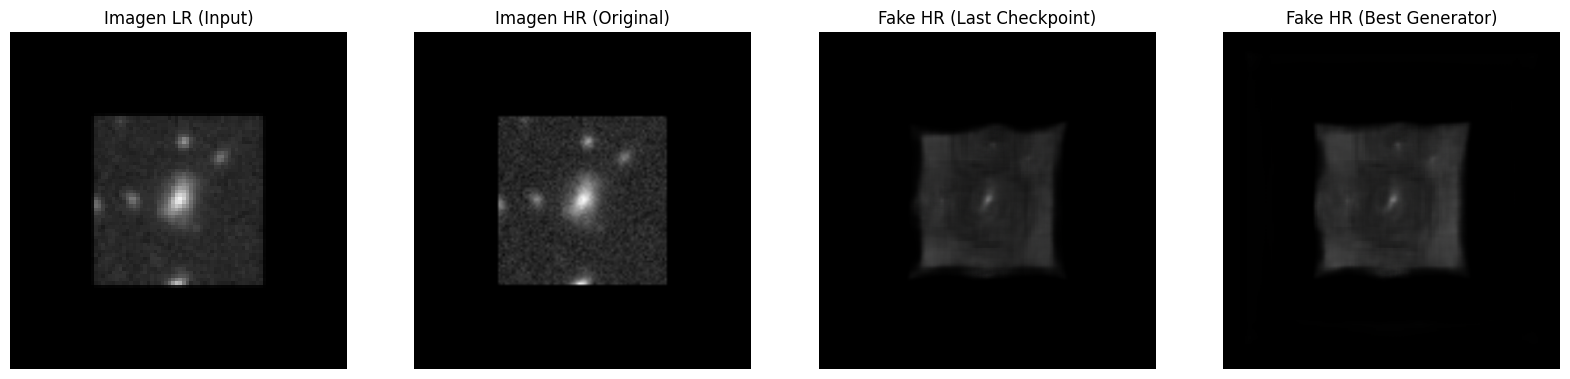

In [ ]:
import torch
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
from PIL import Image
import matplotlib.pyplot as plt
from SRGAN.model import Generator, Discriminator  # Ajusta import si hace falta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ruta modelos
save_dir = 'checkpoints'
checkpoint1 = "/content/checkpoint_epoch_10.pth"
checkpoint2 = "/content/checkpoint_epoch_12.pth"

# Crear el generador (igual que en entrenamiento)
generator = Generator(scale_factor=4).to(device)
generator.eval()

# Transform para preparar imagen: ajusta según tu dataset (ejemplo: 96x96 HR, 24x24 LR)
hr_transform = Compose([
    Resize((384, 384)),
    ToTensor()
])
lr_transform = Compose([
    Resize((96, 96)),
    ToTensor()
])

# Cargar imagen de prueba (puedes usar tu propia ruta)
img_path = "/content/n1_166_340135.png"
img = Image.open(img_path).convert('RGB')
hr_img = hr_transform(img).unsqueeze(0).to(device)  # Batch 1, HR
lr_img = lr_transform(img).unsqueeze(0).to(device)  # Batch 1, LR

# Cargar último checkpoint completo (para obtener generador con optimizadores si quieres)
checkpoint = torch.load(checkpoint1, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])

# Generar imagen con el último modelo
with torch.no_grad():
    fake_hr_last = generator(lr_img)

# Cargar el mejor generador (solo pesos del generador)
best_generator = Generator(scale_factor=4).to(device)
checkpoint_best = torch.load(checkpoint2, map_location=device)
best_generator.load_state_dict(checkpoint_best['generator_state_dict'])
best_generator.eval()

# Generar imagen con el mejor modelo
with torch.no_grad():
    fake_hr_best = best_generator(lr_img)

# Convertir tensores a imágenes para mostrar
to_pil = ToPILImage()
hr_img_show = to_pil(hr_img.squeeze().cpu())
lr_img_show = to_pil(lr_img.squeeze().cpu())
fake_hr_last_show = to_pil(fake_hr_last.squeeze().cpu().clamp(0,1))
fake_hr_best_show = to_pil(fake_hr_best.squeeze().cpu().clamp(0,1))

# Mostrar imágenes
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(lr_img_show)
axs[0].set_title('Imagen LR (Input)')
axs[0].axis('off')

axs[1].imshow(hr_img_show)
axs[1].set_title('Imagen HR (Original)')
axs[1].axis('off')

axs[2].imshow(fake_hr_last_show)
axs[2].set_title('Fake HR (Last Checkpoint)')
axs[2].axis('off')

axs[3].imshow(fake_hr_best_show)
axs[3].set_title('Fake HR (Best Generator)')
axs[3].axis('off')

plt.show()

1. Imagen LR (Input)
- Es la imagen de baja resolución (Low Resolution) que se le da como entrada al generador.
- Es la imagen "chiquita" o degradada, que queremos mejorar.

2. Imagen HR (Original)
- Es la imagen de alta resolución (High Resolution) original, la versión "real" o ground truth que queremos que el generador aprenda a imitar.
- Sirve como referencia para comparar la salida generada.

3. Fake HR (Last Checkpoint)
- Es la imagen de alta resolución generada por el modelo que se cargó desde el último checkpoint guardado (el modelo más reciente durante el entrenamiento).
- Muestra cómo está rindiendo el generador justo al final del entrenamiento.

4. Fake HR (Best Generator)
- Es la imagen generada por el modelo guardado como "mejor" (por ejemplo, el que obtuvo la menor pérdida o mejor métrica durante el entrenamiento).
- Generalmente representa el generador que logró el mejor rendimiento hasta ahora.

In [ ]:
import json
with open('checkpoints/train_history.json') as f:
    history = json.load(f)
import matplotlib.pyplot as plt

epochs = [h['epoch'] for h in history]
loss_G = [h['loss_G'] for h in history]
loss_D = [h['loss_D'] for h in history]

plt.plot(epochs, loss_G, label='Loss G')
plt.plot(epochs, loss_D, label='Loss D')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.grid(True)
plt.show()


In [ ]:
# tarda 4 horas y 30 min por epoch
import torch
from torch import nn, optim
from tqdm import tqdm
from SRGAN.model import Generator, Discriminator  # Ajusta según tu estructura
from SRGAN.loss import GeneratorLoss  # Si usas una clase de pérdida combinada, opcional

# Modelos
generator = Generator(scale_factor=4)
discriminator = Discriminator()

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

# Pérdidas
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_content = nn.MSELoss()

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Entrenamiento
num_epochs = 100

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, leave=False)

    for batch in loop:
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        ##################################
        # Paso 1: Entrenar el Discriminador
        ##################################
        with torch.no_grad():
            fake_hr = generator(lr)  # No calcular gradientes aquí

        real_out = discriminator(hr)
        fake_out = discriminator(fake_hr.detach())

        loss_real = criterion_GAN(real_out - fake_out.mean(), torch.ones_like(real_out))
        loss_fake = criterion_GAN(fake_out - real_out.mean(), torch.zeros_like(fake_out))
        loss_D = (loss_real + loss_fake) / 2

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        ##################################
        # Paso 2: Entrenar el Generador
        ##################################
        fake_hr = generator(lr)
        fake_out = discriminator(fake_hr)

        loss_content = criterion_content(fake_hr, hr)
        loss_adv = criterion_GAN(fake_out - real_out.mean().detach(), torch.ones_like(fake_out))
        loss_G = loss_content + 1e-3 * loss_adv

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        ##################################
        # Mostrar progreso
        ##################################
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())

    torch.cuda.empty_cache()  # opcional, para evitar acumulación entre épocas

Epoch [1/100]:   1%|          | 558/51565 [03:01<4:38:07,  3.06it/s, loss_D=0.314, loss_G=0.00209]

In [ ]:
import torch
from torch import nn, optim
from tqdm import tqdm
from SRGAN.model import Generator, Discriminator  # Si estás usando el repo clonado

# Modelos
generator = Generator(scale_factor=4)
discriminator = Discriminator()

# Dispositivos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

# Pérdidas
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_content = nn.MSELoss()

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Entrenamiento
for epoch in range(100):
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, leave=False)
    for batch in loop:
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        # Train D
        fake_hr = generator(lr)
        real_out = discriminator(hr)
        fake_out = discriminator(fake_hr.detach())

        loss_real = criterion_GAN(real_out - fake_out.mean(), torch.ones_like(real_out))
        loss_fake = criterion_GAN(fake_out - real_out.mean(), torch.zeros_like(fake_out))
        loss_D = (loss_real + loss_fake) / 2

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train G
        fake_hr = generator(lr)
        fake_out = discriminator(fake_hr)

        loss_content = criterion_content(fake_hr, hr)
        loss_adv = criterion_GAN(fake_out - real_out.mean(), torch.ones_like(fake_out))
        loss_G = loss_content + 1e-3 * loss_adv

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        loop.set_description(f"Epoch [{epoch+1}/100]")
        loop.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())


cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 576.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 32.12 MiB is free. Process 14259 has 14.71 GiB memory in use. Of the allocated memory 14.22 GiB is allocated by PyTorch, and 379.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torchvision.utils as vutils

generator.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        lr = batch['lr'].to(device)
        sr = generator(lr)
        vutils.save_image(sr, f"sr_output_{i}.png", normalize=True)
        vutils.save_image(batch['hr'], f"hr_target_{i}.png", normalize=True)


#Paso 1: Descarga y carga del generador preentrenado

In [ ]:
import tensorlayerx as tlx
from tensorlayerx.models.srgan import SRGAN_g

# Cargar generador preentrenado (weights pretrained en DIV2K)
generator = SRGAN_g()
generator.set_eval()
tlx.files.load_and_assign_npz(name='pretrained_srgan_g.npz', network=generator)

# Ahora generator está listo para seguir entrenando/fine-tuning

Create the backend configuration file :/root/.tl/tl_backend.json
Using TensorFlow backend.
/usr/local/lib/python3.11/dist-packages/tensorlayerx/__init__.py:45: UserWarning: The version of the backend you have installed does not match the specified backend version and may not work, please install version tensorflow 2.4.0.
  warnings.warn("The version of the backend you have installed does not match the specified backend version "


ModuleNotFoundError: No module named 'tensorlayerx.models'

#Paso 2: Cargar tus datos en pares LR-HR, sin clases

In [ ]:
import os
import numpy as np
from PIL import Image

def load_img(path, size=None):
    img = Image.open(path).convert('RGB')
    if size is not None:
        img = img.resize(size, Image.BICUBIC)
    img = np.array(img).astype(np.float32)
    img = (img / 127.5) - 1  # normalizar [-1,1]
    return img

def load_pairs(lr_dir, hr_dir):
    lr_imgs = sorted(os.listdir(lr_dir))
    hr_imgs = sorted(os.listdir(hr_dir))
    pairs = []
    for fn in lr_imgs:
        if fn in hr_imgs:
            pairs.append((os.path.join(lr_dir, fn), os.path.join(hr_dir, fn)))
    return pairs

train_pairs = load_pairs('/content/split_data/train/acs', '/content/split_data/train/dud')
val_pairs = load_pairs('/content/split_data/val/acs', '/content/split_data/val/dud')


#Paso 3: Data generator para batch

In [ ]:
def data_generator(pairs, batch_size=4):
    while True:
        batch = np.random.choice(pairs, batch_size)
        lr_batch, hr_batch = [], []
        for lr_path, hr_path in batch:
            lr_img = load_img(lr_path, size=(152,152))
            hr_img = load_img(hr_path, size=(520,520))
            lr_batch.append(lr_img)
            hr_batch.append(hr_img)
        yield np.array(lr_batch), np.array(hr_batch)


#Paso 4: Entrenar/fine-tunear generador preentrenado con MSE primero

In [ ]:
import tensorflow as tf

generator.train()

mse_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def pretrain_step(lr_imgs, hr_imgs):
    with tf.GradientTape() as tape:
        sr_imgs = generator(lr_imgs, training=True)
        loss = mse_loss(hr_imgs, sr_imgs)
    grads = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return loss
